In [ ]:
from cppredictor import build_conformal_predictor
from cppredictor import coco_label_from_index
import valToCal
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import load_coco_json

import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import json
import numpy as np
from pycocotools.coco import COCO

In [2]:
# Configure Detectron Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6 # set IoU threshold
cfg.MODEL.DEVICE = 'cuda'  # 명시적으로 GPU 사용 지정

predictor = build_conformal_predictor(cfg)
predictor.load_calibration("calib_scores.json")

test_img_path = "input.jpg"
test_img = cv2.imread(test_img_path)  # → numpy.ndarray
outputs = predictor(test_img)

Using device: cuda
ConformalPredictor initialized with hooks


/opt/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TypeError: list indices must be integers or slices, not str

In [19]:
print(len(outputs["instances"].pred_classes))
pred_classes = coco_label_from_index(outputs["instances"].pred_classes)
print(pred_classes)

18
['horse', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'umbrella', 'umbrella', 'umbrella', 'person', 'person', 'umbrella', 'umbrella', 'person', 'person']


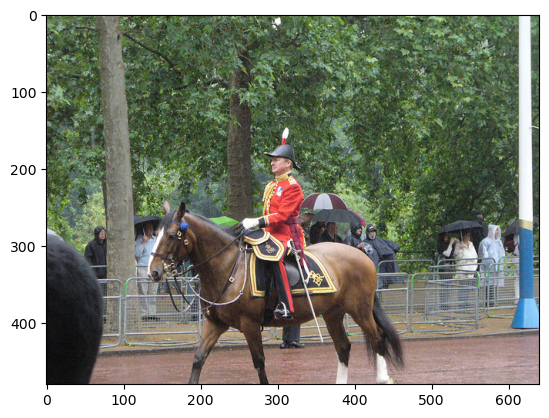

In [20]:
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [21]:
### get calibrations with the model

image_root = "/home/datasets/coco/val2017"
json_file = "/home/datasets/coco/annotations/instances_val2017.json"

evaluator = valToCal.CalibrationEvaluator(image_root, json_file, predictor)

In [22]:
#calibration_scores = evaluator.run()
calibration_scores = evaluator.load_results("calib.json")
print(len(calibration_scores))

80


In [23]:
'''
try:
    evaluator.save_results(calibration_scores, "calib.json")
except Exception as e:
    print(f"Error using evaluator.save_results: {e}")
    # Backup approach: serialize the data ourselves
    # Convert keys to strings and make sure all nested elements are serializable
    serializable_scores = {str(k): [score.tolist() if hasattr(score, 'tolist') else score for score in v] 
                         for k, v in calibration_scores.items()}
    
    with open("calib.json", "w") as f:
        json.dump(serializable_scores, f)
    
print("Calibration scores saved to calib.json")
'''

'\ntry:\n    evaluator.save_results(calibration_scores, "calib.json")\nexcept Exception as e:\n    print(f"Error using evaluator.save_results: {e}")\n    # Backup approach: serialize the data ourselves\n    # Convert keys to strings and make sure all nested elements are serializable\n    serializable_scores = {str(k): [score.tolist() if hasattr(score, \'tolist\') else score for score in v] \n                         for k, v in calibration_scores.items()}\n    \n    with open("calib.json", "w") as f:\n        json.dump(serializable_scores, f)\n    \nprint("Calibration scores saved to calib.json")\n'

In [24]:
alpha = 0.1
classwise_qhat = evaluator.compute_classwise_quantiles(aggregated_results=calibration_scores, alpha=alpha)
print(classwise_qhat.keys())

dict_keys([58, 62, 56, 0, 72, 74, 39, 75, 21, 59, 73, 11, 7, 77, 30, 69, 32, 38, 26, 14, 8, 24, 67, 55, 45, 37, 63, 64, 66, 2, 5, 15, 4, 22, 60, 27, 9, 47, 34, 43, 40, 41, 46, 33, 61, 50, 36, 51, 57, 65, 18, 6, 71, 35, 20, 29, 25, 19, 17, 16, 3, 1, 68, 42, 53, 10, 28, 48, 13, 44, 23, 54, 52, 31, 49, 12, 79, 70, 76, 78])


In [25]:
# COCO validation 이미지 루트와 annotation 경로
test_image_root = "/home/datasets/coco/val2017"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"

# validation dataset 중 하나 불러오기
test_dataset_dicts = load_coco_json(test_json_file, test_image_root, dataset_name="coco_val2017")

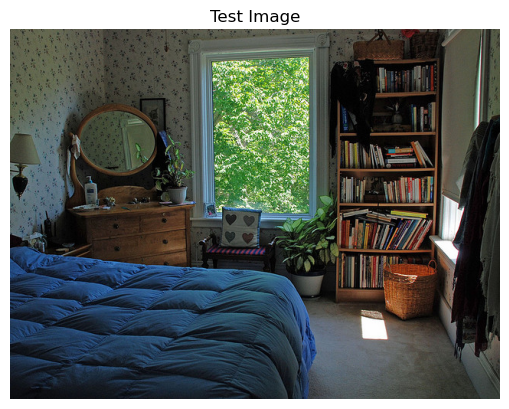

In [26]:
test_sample = test_dataset_dicts[2]

# 이미지 로드 및 출력
image_path = test_sample["file_name"]
test_image = cv2.imread(image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plt.imshow(test_image_rgb)
plt.title("Test Image")
plt.axis("off")
plt.show()

In [27]:
conformal_out = predictor(test_image)
# 예측 결과
#print(conformal_out["instances"])
#print(conformal_out["instances"].scores)
print(conformal_out["instances"].pred_classes)
#output_classes = coco_label_from_index(conformal_out["instances"].pred_classes.item())
for i in range(len(conformal_out["instances"].pred_classes)):
  print(f"{i} : {conformal_out['instances'].pred_classes[i]} : {coco_label_from_index(conformal_out['instances'].pred_classes[i])}")

instances = conformal_out["instances"].to("cpu")
pred_classes = instances.pred_classes.numpy()
scores = instances.scores.numpy()
nonconformity_score = 1 - scores


tensor([56, 59, 58, 58, 39, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 73, 73, 73, 73], device='cuda:0')
0 : 56 : chair
1 : 59 : bed
2 : 58 : potted plant
3 : 58 : potted plant
4 : 39 : bottle
5 : 73 : book
6 : 73 : book
7 : 73 : book
8 : 73 : book
9 : 73 : book
10 : 73 : book
11 : 73 : book
12 : 73 : book
13 : 73 : book
14 : 73 : book
15 : 73 : book
16 : 73 : book
17 : 73 : book
18 : 73 : book
19 : 73 : book
20 : 73 : book
21 : 73 : book
22 : 73 : book
23 : 73 : book


In [28]:
q_hat = evaluator.compute_global_quantile(calibration_scores, alpha=alpha)

print(conformal_out["instances"].class_probs[2])

conf_thr = 1-q_hat
print(f"conf_thr: {conf_thr}")
# 마스크로 q_hat을 넘지 않는 클래스를 제거
mask = conformal_out["instances"].class_probs >= q_hat
print(mask[0])


tensor([5.7879e-05, 1.4341e-05, 3.8502e-06, 5.2462e-06, 2.5026e-07, 2.7810e-06,
        1.0267e-06, 4.0906e-06, 2.7159e-06, 6.4447e-07, 6.3078e-06, 3.6784e-07,
        1.0025e-06, 3.4014e-05, 3.4836e-06, 2.5807e-05, 2.6211e-06, 2.4200e-06,
        2.2772e-06, 1.9021e-06, 1.8789e-06, 1.0274e-06, 7.5559e-06, 6.6704e-06,
        5.7155e-06, 7.0766e-06, 9.2377e-06, 5.0477e-07, 3.8376e-06, 1.7500e-07,
        2.2781e-07, 1.8248e-07, 1.5842e-06, 5.2966e-06, 2.6910e-07, 6.8040e-07,
        9.1438e-07, 2.3476e-07, 6.9237e-07, 3.6931e-06, 1.0506e-06, 6.0896e-06,
        9.0582e-08, 1.6338e-07, 4.8138e-07, 1.9970e-05, 6.9141e-06, 2.4122e-06,
        1.0858e-06, 1.5991e-06, 1.9385e-05, 6.4978e-07, 5.9012e-07, 5.6053e-06,
        2.2664e-07, 2.1919e-06, 3.4651e-04, 2.9535e-04, 9.9411e-01, 6.1346e-06,
        1.5105e-05, 4.7034e-06, 2.2854e-05, 5.1634e-07, 9.2573e-08, 1.8592e-07,
        7.0569e-07, 3.7889e-08, 8.8048e-07, 3.6590e-06, 6.0012e-07, 3.1054e-06,
        1.6207e-05, 2.9003e-06, 1.7282e-

In [29]:
pred_sets = [torch.where(mask[i])[0].tolist() for i in range(mask.shape[0])]
print(pred_sets, len(pred_sets))
print(coco_label_from_index(pred_sets[0]))


[[56], [59], [58], [58], [39], [73], [73], [73], [73], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80]] 24
['chair']


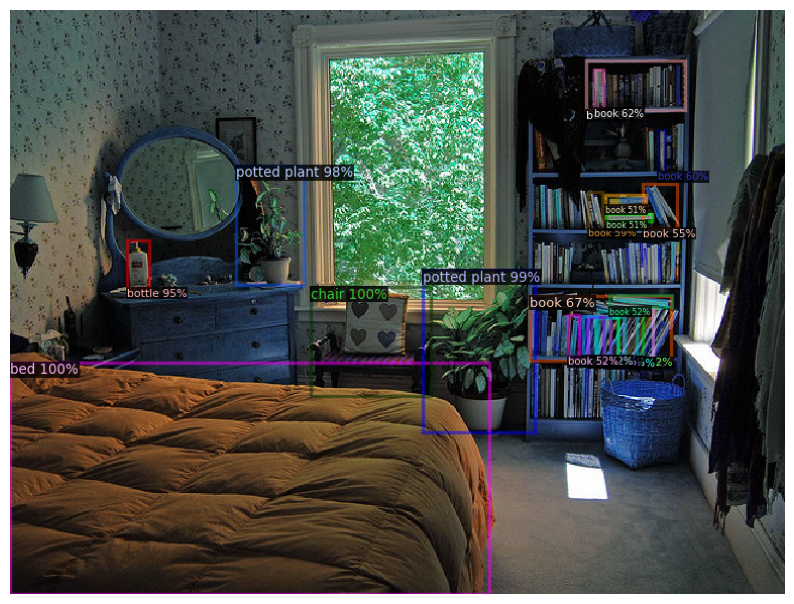

In [30]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(test_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(conformal_out["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()